In [1]:
import json

import matplotlib.pyplot as plt

In [11]:
def merge_training_states(training_states: list[str]) -> tuple[list, list, list, list]:
    start_steps = 0
    eval_loss = []
    train_loss = []
    eval_accuracy = []
    steps = []
    for training_state in training_states:
        with open(training_state + "/trainer_state.json") as f:
            instruct_metrics = json.load(f)
            log_history = instruct_metrics["log_history"]

            for log in log_history:
                if "eval_loss" in log:
                    eval_loss.append(log["eval_loss"])
                    steps.append(log["step"] + start_steps)
                if "loss" in log:
                    train_loss.append(log["loss"])
                if "eval_accuracy" in log:
                    eval_accuracy.append(log["eval_accuracy"])
            start_steps = steps[-1]
    return eval_loss, train_loss, eval_accuracy, steps

In [12]:
path_to_save_metrics = "../../../results/llama3_results/classification_head/metrics"
training_states = [
    path_to_save_metrics + "/run_1",
    path_to_save_metrics + "/run_2",
    path_to_save_metrics + "/run_3",
]

In [13]:
eval_loss, train_loss, eval_accuracy, steps = merge_training_states(training_states)

In [22]:
print(len(steps))

27


In [15]:
assert len(eval_loss) == len(train_loss), "Length must match"
assert len(eval_loss) == len(steps), "Length must match"
assert len(eval_accuracy) == len(steps), "Length must match"

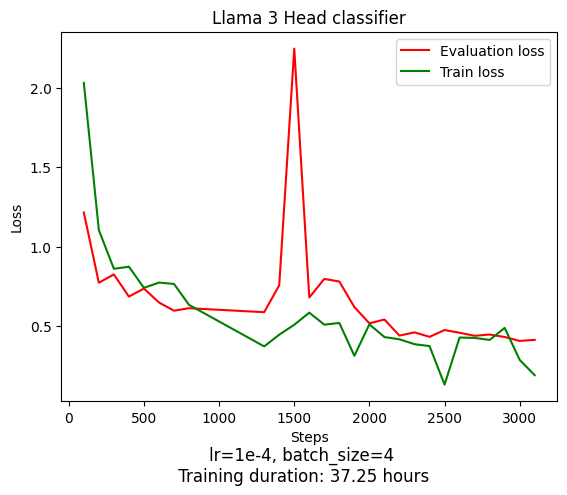

In [23]:
# Instruct finetuning metrics
fig, ax = plt.subplots()

ax.plot(steps, eval_loss, "r-", label="Evaluation loss")
ax.plot(steps, train_loss, "g-", label="Train loss")
ax.set_xlabel("Steps")
ax.set_ylabel("Loss", color="black")
ax.legend()
plt.title("Llama 3 Head classifier")
txt = "lr=1e-4, batch_size=4\n Training duration: 37.25 hours"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment="center", fontsize=12)

plt.savefig(path_to_save_metrics + "/training_loss.png")
plt.show()

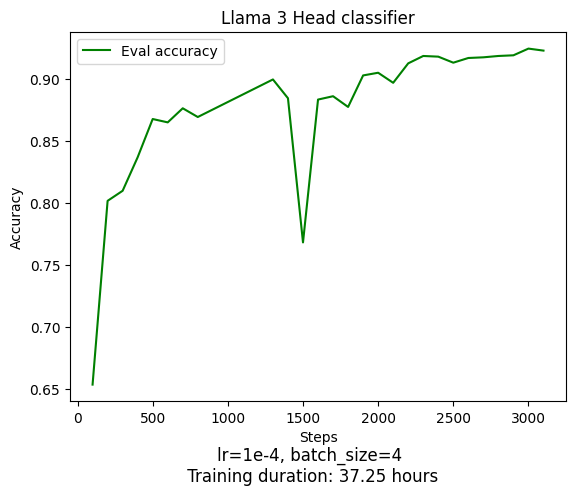

In [24]:
fig, ax = plt.subplots()

ax.plot(steps, eval_accuracy, "g-", label="Eval accuracy")
ax.set_xlabel("Steps")
ax.set_ylabel("Accuracy", color="black")
ax.legend()
plt.title("Llama 3 Head classifier")
txt = "lr=1e-4, batch_size=4\n Training duration: 37.25 hours"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment="center", fontsize=12)

plt.savefig(path_to_save_metrics + "/training_accuracy.png")
plt.show()

In [ ]:
from collections import Counter

import matplotlib.pyplot as plt
import torch
from Scripts.llama_model_wrapper import HeadClassifierWrapper, InstructModelWrapper
from Scripts.load_dataset import add_label_id, load_dataset
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
)
from transformers import BitsAndBytesConfig

In [ ]:
_, test_ds = load_dataset(
    "../../../../German_newspaper_articles/10kGNAD/train.csv",
    "../../../../German_newspaper_articles/10kGNAD/test.csv",
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instruction metrics

In [ ]:
model_kwargs = {
    "path": "../../../results/llama3_results/instruct/model.nosync",
    "tokenizer_path": "meta-llama/Meta-Llama-3-8B-Instruct",
    "torch_dtype": torch.bfloat16,
    "device_map": "auto",
}

In [ ]:
instruct_model_wrapper = InstructModelWrapper(**model_kwargs)

In [ ]:
test_ds = test_ds.map(
    instruct_model_wrapper.create_test_messages, remove_columns=["text"]
)

In [ ]:
test_ds = test_ds.map(instruct_model_wrapper.tokenize_messages)

In [ ]:
test_ds.set_format("torch", device=device)

In [ ]:
correct = 0
correct_dict = {
    "Web": 0,
    "International": 0,
    "Etat": 0,
    "Wirtschaft": 0,
    "Panorama": 0,
    "Sport": 0,
    "Wissenschaft": 0,
    "Kultur": 0,
    "Inland": 0,
}
y_true = []
y_pred = []
wrong = []
instruct_model_wrapper.model.eval()
for i, sample in enumerate(test_ds):
    outputs = instruct_model_wrapper.model.generate(
        sample["input_ids"],
        max_new_tokens=128,
        eos_token_id=instruct_model_wrapper.terminators,
        do_sample=False,
        temperature=0.1,
        top_p=0.9,
    )
    response = outputs[0][sample["input_ids"].shape[-1] :]
    response = instruct_model_wrapper.tokenizer.decode(
        response, skip_special_tokens=True
    )
    y_true.append(sample["label"])
    y_pred.append(response)
    if sample["label"] in response:
        correct += 1
        correct_dict[sample["label"]] += 1
        print(f"At {i}: {response}")

In [ ]:
assert len(set(y_true)) == len(set(y_pred)), "Labels are not the same"

In [ ]:
label_counts = Counter(test_ds["label"])
label_counts

In [ ]:
labels = list(label_counts.keys())
differences = dict()
for label in labels:
    differences[label] = correct_dict[label] / label_counts[label]

In [ ]:
path_to_save_metrics = "../../../results/llama3_results/instruct/metrics"

difference_values = [value * 100 for value in differences.values()]
difference_labels = [value for value in differences.keys()]
fig, ax = plt.subplots()

xs = range(len(difference_labels))
ys = [difference_values[x] for x in xs]

ax.bar(difference_labels, ys, 0.6)
plt.title("correct per category")
plt.xlabel("category")
plt.ylabel("accuracy in %")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
plt.savefig(path_to_save_metrics + "/test_evaluation.png")

plt.show()

In [ ]:
cm = confusion_matrix(
    y_true,
    y_pred,
    labels=[
        "Web",
        "International",
        "Etat",
        "Wirtschaft",
        "Panorama",
        "Sport",
        "Wissenschaft",
        "Kultur",
        "Inland",
    ],
)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
accuracy_score(y_true, y_pred)

In [ ]:
f1_score(y_true, y_pred, average="weighted")

# Classifaction head metrics

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [ ]:
finetuned_model_path = (
    "../../../results/llama3_results/classification_head/run_3/model/finetuned"
)

In [ ]:
classification_wramodel_kwargs = {
    "path": finetuned_model_path,
    "num_labels": 9,
    "tokenizer_path": "../../../results/llama3_results/classification_head/run_3/metrics/checkpoint-1800",
    "device_map": "cuda",
    "use_cache": False,
    "quantization_config": quantization_config,
}

In [ ]:
classification_wrapper = HeadClassifierWrapper(**model_kwargs)

In [ ]:
test_ds = test_ds.map(classification_wrapper.tokenize_text, remove_columns=["text"])

In [ ]:
test_ds = test_ds.map(add_label_id)

In [ ]:
test_ds.set_format("torch", device=device)

In [ ]:
correct = 0
correct_dict = {
    "Web": 0,
    "International": 0,
    "Etat": 0,
    "Wirtschaft": 0,
    "Panorama": 0,
    "Sport": 0,
    "Wissenschaft": 0,
    "Kultur": 0,
    "Inland": 0,
}
y_true = []
y_pred = []
classification_wrapper.model.eval()
for i, sample in enumerate(test_ds):
    output = classification_wrapper.model(
        torch.unsqueeze(sample["input_ids"], 0),
        torch.unsqueeze(sample["attention_mask"], 0),
    ).logits
    output = torch.argmax(output).item()
    y_true.append(sample["label_id"])
    y_pred.append(output)
    if output == sample["label_id"]:
        correct += 1
        correct_dict[sample["label"]] += 1
        print(f"At {i}: {output}")

In [ ]:
cm = confusion_matrix(
    y_true,
    y_pred,
)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
accuracy_score(y_true, y_pred)

In [ ]:
f1_score(y_true, y_pred, average="weighted")